In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
from scipy.misc import face
A = face(gray = True)

print "Shape of the matrix is ", A.shape
u,s,vh = np.linalg.svd(A, full_matrices = False)

Shape of the matrix is  (768, 1024)


# Leverage score approach

In [3]:
from scipy import stats
from scipy.linalg import qr

def cssp_leverage(A, vh, k = 20, beta = 0.5):
    
    Vk = vh[:k,:].T
    
    n = Vk.shape[0]
    #Compute leverage scores
    score = np.sum(Vk**2.,1)
    
    
    #Define discrete probability
    xk = np.arange(n)
    pk = beta*score/k + (1-beta)*1./n
    lev =  stats.rv_discrete(name='lev', values=(xk, pk))
    
    #number of samples to be drawn
    c = np.int(3*k*np.log(k))
    
    rand_sample = lev.rvs(size = c)
    
    fact = 1./np.sqrt(c*pk[rand_sample])
    C = np.dot(A[:,rand_sample], np.diag(fact))
               
    #Efficient implementation of pseudoinverse
    X = np.dot(np.linalg.pinv(C),A)
    
    return C, X, rand_sample

Number of samples was 241


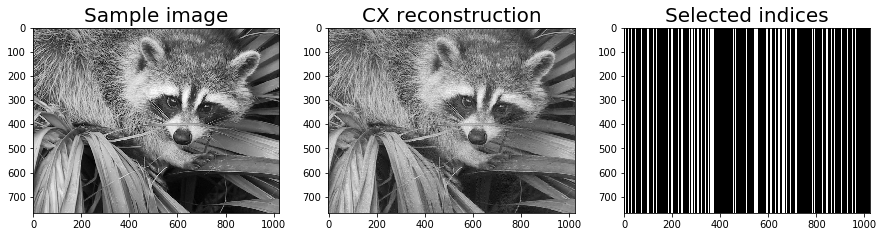

The error in the reconstruction was  0.01537979964038214


In [4]:
C, X, p = cssp_leverage(A, vh, beta = 0.9, k = 25)
print "Number of samples was", p.size

# To visualize Selected indices
I = 0.*A
I[:,p] = 1.

#Plot the reconstructed image
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))
ax1.imshow(A, cmap=plt.cm.gray)
ax1.set_title('Sample image', fontsize = 20)
ax2.imshow(np.dot(C,X), cmap=plt.cm.gray)
ax2.set_title('CX reconstruction', fontsize = 20)


ax3.imshow(I, cmap=plt.cm.gray)
ax3.set_title('Selected indices', fontsize = 20)
plt.show()

print "The error in the reconstruction was ", np.linalg.norm(A-np.dot(C,X),2)/s[0]

# Hybrid approach

In [5]:
def cssp_hybrid(A, vh, k = 20, beta = 0.5):
    
    Vk = vh[:k,:].T
    
    n = Vk.shape[0]
    #Compute leverage scores
    score = np.sum(Vk**2.,1)
    
    
    
    #Define discrete probability
    xk = np.arange(n)
    pk = beta*score/k + (1-beta)*1./n
    lev =  stats.rv_discrete(name='lev', values=(xk, pk))
    
    #number of samples to be drawn
    c = np.int(3*k*np.log(k))
    
    rand_sample = lev.rvs(size = c)
    
    fact = 1./np.sqrt(c*pk[rand_sample])
    
    # Stage 2: the deterministic part
    SVk = np.dot(Vk[rand_sample, :].T, np.diag(fact))
    _,_,p = qr(SVk, pivoting = True, mode = 'economic')
    p = p[:k]   
    
    C = np.dot(A[:,rand_sample[p]], np.diag(fact[p]))
               
    #Efficient implementation of pseudoinverse
    X = np.dot(np.linalg.pinv(C),A)
    
    return C, X, p

Number of samples was 25


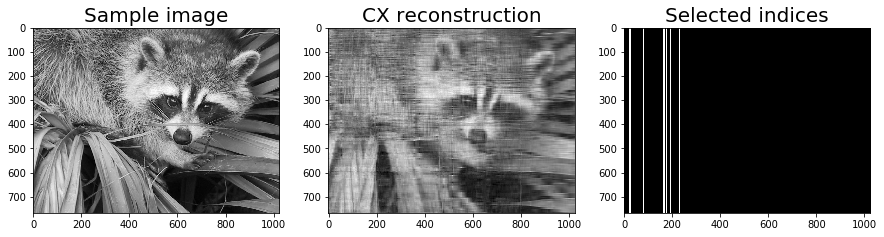

The error in the reconstruction was  0.05119326855011627


In [6]:
C, X, p = cssp_hybrid(A, vh, beta = 0.9, k = 25)
print "Number of samples was", p.size

# To visualize Selected indices
I = 0.*A
I[:,p] = 1.

#Plot the reconstructed image
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))
ax1.imshow(A, cmap=plt.cm.gray)
ax1.set_title('Sample image', fontsize = 20)
ax2.imshow(np.dot(C,X), cmap=plt.cm.gray)
ax2.set_title('CX reconstruction', fontsize = 20)


ax3.imshow(I, cmap=plt.cm.gray)
ax3.set_title('Selected indices', fontsize = 20)
plt.show()

print "The error in the reconstruction was ", np.linalg.norm(A-np.dot(C,X),2)/s[0]


Text(0.5,1,'Frobenius-norm ')

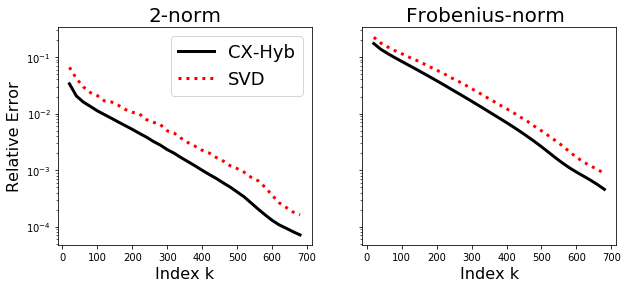

In [7]:
ranks = range(20,700,20)

error  = np.zeros((len(ranks),4))
A2nrm  = np.linalg.norm(A, 2)
Afnrm  = np.linalg.norm(A, 'fro')


#Compute the partial errors and storage costs
for i, r in enumerate(ranks):
    C, X, p = cssp_hybrid(A, vh, beta = 0.9, k = r)
    Ah = np.dot(C,X)
    
    #Spectral norm
    error[i,0] = s[r]/A2nrm
    error[i,1] = np.linalg.norm(A-Ah,2)/A2nrm

    # Frobenius norm
    error[i,2] = np.sqrt(np.sum(s[r:]**2.))/Afnrm
    error[i,3] = np.linalg.norm(A-Ah)/Afnrm
    
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy(ranks,error[:,0],  'k-', ranks,error[:,1], 'r:', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Relative Error', fontsize = 16)
ax1.legend({'SVD','CX-Hyb'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy(ranks,error[:,2],  'k-', ranks,error[:,3], 'r:', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)